### Importing Libraries

In [ ]:
pip install -q -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.3 MB/s eta 0:00:00


In [ ]:
pip install -q torch_optimizer numpy torch transformers evaluate python-whois

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.8 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Import label encoder
from sklearn import preprocessing, metrics

import itertools
from sklearn.metrics import classification_report, mean_squared_error,confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, auc,roc_curve
from sklearn.model_selection import train_test_split
import random
import math
from collections import Counter
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import os
import socket
import whois
from datetime import datetime
import time
from bs4 import BeautifulSoup
import urllib
import bs4
import os

### EDA

In [ ]:
df = pd.read_csv('shuffled.csv')

In [ ]:
df.head()

,text,label
0,https://tools.ietf.org/html/rfc1150,0
1,http://pastehtml.com/view/bevew8kur.html,1
2,http://datahelp.me/login,1
3,http://www.sco.com/skunkware/faq.html,0
4,http://www.tpacc.co.za/,1


In [ ]:
print(df.shape)
print(df.info())

(83117, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83117 entries, 0 to 83116
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    83117 non-null  object
 1   label   83117 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
None


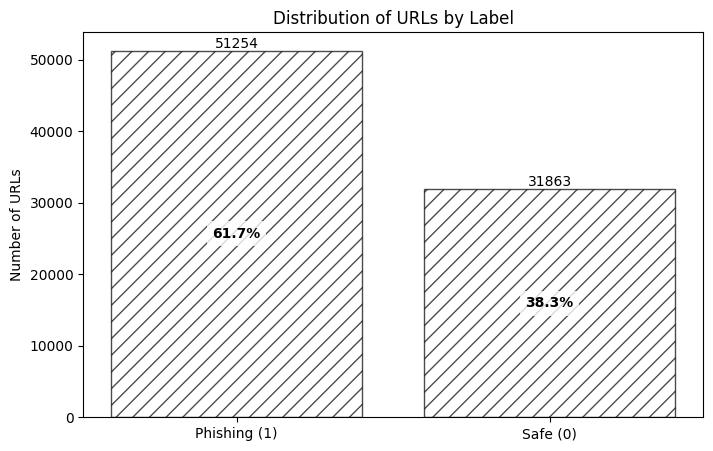

Counter({np.int64(1): 51254, np.int64(0): 31863})


In [ ]:
labels = df['label'].values

# Count occurrences of each label
counter_labels = Counter(labels)

# Prepare names and values
label_names = ['Safe (0)', 'Phishing (1)']  # more descriptive
label_values = [counter_labels.get(0, 0), counter_labels.get(1, 0)]

# Sort by values descending
sorted_indices = np.argsort(label_values)[::-1]
label_names = [label_names[i] for i in sorted_indices]
label_values = [label_values[i] for i in sorted_indices]

# Percentages
total_count = sum(label_values)
percentages = [value / total_count * 100 for value in label_values]

# Plotting
pattern = '//'
y_pos = np.arange(len(label_names))
plt.figure(1, figsize=(8, 5))
bars = plt.bar(y_pos, label_values, align='center', alpha=0.7, color='none', edgecolor='black', hatch=pattern)

# Add counts and percentages on bars
for bar, value, percentage in zip(bars, label_values, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{value}', ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{percentage:.1f}%', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'), fontweight='bold')

plt.xticks(y_pos, label_names)
plt.ylabel('Number of URLs')
plt.title('Distribution of URLs by Label')
plt.show()

print(counter_labels)


### Data transformation

In [ ]:
#convert to Hugging Face Dataset:
dataset = Dataset.from_pandas(df, preserve_index=False)
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 83117
})

In [ ]:
# split train to 80% of total and test to 20% of total
train_test_dataset = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 66493
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 16624
    })
})

In [ ]:
from datasets import DatasetDict
# 80% train, 20% test
dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'test': train_test_dataset['test'],
})
df_train = dataset['train'].to_pandas()
df_test = dataset['test'].to_pandas()
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 66493
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 16624
    })
})

### Feature Engineering




#### Check IP

To disguise the identity of a website, online criminals frequently use an Internet protocol address instead of the domain name server. This feature will determine if the URL contains an IP address or not

In [ ]:
import re
def having_ip_address(url):
    match = re.search(
        r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'  # IPv4
        r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)|'  # IPv4 hexadecimal
        r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}',  # IPv6
        url
    )
    return 1 if match else 0

# Apply to your dataset using the correct column name 'text'
df_train['use_of_ip'] = df_train['text'].apply(lambda i: having_ip_address(i))
df_test['use_of_ip'] = df_test['text'].apply(lambda i: having_ip_address(i))

df_train

: 

#### Count of dot (.)

The URLs of phishing or malware websites frequently contain more than two subdomains. A dot separates each domain (.). Every URL with more than three dot characters (.) raises the risk of a malicious website

In [ ]:
df_train['count (.)'] = df_train['text'].apply(lambda i: i.count('.'))
df_test['count (.)'] = df_test['text'].apply(lambda i: i.count('.'))

df_train.head()

#### Count of WWW (www.)

This feature ignores the leading www. and flags URLs containing additional www. substrings. Since legitimate websites typically have zero or one www, this effectively detects fraudulent URLs that use multiple www instances to mimic trusted domains.

In [ ]:
df_train['count-www'] = df_train['text'].apply(lambda i: i.count('www'))
df_test['count-www'] = df_test['text'].apply(lambda i: i.count('www'))
df_train

#### Count (@)

If the URL contains the "@" sign, everything before it is ignored


In [ ]:
df_train['count@'] = df_train['text'].apply(lambda i: i.count('@'))
df_test['count@'] = df_test['text'].apply(lambda i: i.count('@'))
df_train

#### Count Dir / URL Depth

Websites that have several directories in their URLs are typically suspect

In [ ]:
from urllib.parse import urlparse
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df_train['count_dir'] = df_train['text'].apply(lambda i: no_of_dir(i))
df_test['count_dir'] = df_test['text'].apply(lambda i: no_of_dir(i))
df_train

#### Count Embed Domain

Knowing how many embedded domains there are will help you spot dangerous URLs. You may accomplish it by looking for the character "//" in the URL

In [ ]:
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df_train['count_embed_domain'] = df_train['text'].apply(lambda i: no_of_embed(i))
df_test['count_embed_domain'] = df_test['text'].apply(lambda i: no_of_embed(i))
df_train

#### Count Suspicious URL

In [ ]:
def suspicious_words(url):
    """
    Enhanced suspicious URL detection focusing on contextual patterns
    rather than just word presence to reduce false positives
    """
    # Convert to lowercase for case-insensitive matching
    url_lower = url.lower()

    # High-confidence suspicious patterns
    suspicious_patterns = [
        # Pattern 1: Security words in domain name (not just path)
        r'^(?:[a-z0-9-]*\.)?(security|auth|login|verify|password|account|credential|token)\.',

        # Pattern 2: Brand + security word combinations (paypal-login.com)
        r'(paypal|bank|amazon|apple|google|microsoft|netflix|facebook|instagram)[-_\.](login|verify|security|account|password|auth)',

        # Pattern 3: Brand misspellings with security context
        r'(paypa1|paypai|arnazon|micr0soft|go0gle|app1e|faceb00k)[-_\.](login|verify|account)',

        # Pattern 4: Multiple security words in subdomain/path
        r'(login|auth|account).*(password|secure|verify)|(password|secure).*(login|auth|account)',

        # Pattern 5: High-risk words that are rarely legitimate in domains
        r'credential|passwd|pwd[0-9]|ssn[0-9]|socialsecurity|otp[0-9]|mfa[0-9]',

        # Pattern 6: Suspicious TLD patterns (you can expand this based on your data)
        r'\.(tk|ml|ga|cf|gq|xyz)/(login|auth|admin|secure|account|verify)',
    ]

    # Check for high-confidence patterns first
    for pattern in suspicious_patterns:
        if re.search(pattern, url_lower):
            return 1

    # Medium-confidence: Individual high-risk words in specific contexts
    high_risk_words = [
        r'credential', r'password', r'passwd', r'pwd', r'pin', r'token',
        r'otp', r'mfa', r'2fa', r'biometric', r'ssn', r'socialsecurity'
    ]

    # Only flag if these high-risk words appear in domain or key positions
    domain = url_lower.split('/')[0]  # Get domain part only
    for word in high_risk_words:
        if re.search(word, domain):  # Only check in domain, not full path
            return 1

    # Low-confidence: Original word list but with context awareness
    original_words = r'access|accounts|auth|security|portal|user|admin|identity|login|' \
                    r'privilege|validation|authorize|authentication|session|' \
                    r'transaction|validate|confirmation|billinginfo|accountinfo|' \
                    r'invoiceinfo|orderinfo|payment'

    # Only flag original words if they appear in suspicious combinations
    if re.search(original_words, url_lower, re.IGNORECASE):
        # Additional checks to reduce false positives
        words_found = re.findall(original_words, url_lower, re.IGNORECASE)

        # If multiple suspicious words found, more likely to be malicious
        if len(words_found) >= 2:
            return 1

        # If single word but in domain name (more suspicious)
        domain = url_lower.split('/')[0]
        if re.search(original_words, domain, re.IGNORECASE):
            return 1

    return 0

# Apply to your dataset (same as before)
df_train['sus_url'] = df_train['text'].apply(suspicious_words)
df_test['sus_url'] = df_test['text'].apply(suspicious_words)

df_train.head()

#### Count Shortening URL

This feature tells you whether a URL has been shortened using a service, such as bit.ly, goo.gl, go2l.ink, etc

In [ ]:
def shortening_service(url):
    pattern = (
        r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
        r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
        r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
        r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
        r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
        r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
        r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
        r'tr\.im|link\.zip\.net'
    )
    if re.search(pattern, url, flags=re.IGNORECASE):
        return 1
    else:
        return 0

df_train['short_url'] = df_train['text'].apply(lambda i: shortening_service(i))
df_test['short_url'] = df_test['text'].apply(lambda i: shortening_service(i))
df_train

#### Count HTTPS

Malicious Websites often avoid using HTTPS protocols since they typically demand user login information and guarantee that online transactions are secure. Hence, whether HTTPS is present or not is a key component of the URL.

In [ ]:
df_train['count-https'] = df_train['text'].apply(lambda i : i.count('https'))
df_test['count-https'] = df_test['text'].apply(lambda i : i.count('https'))
df_train

#### Count HTTP

Safe websites typically have a single HTTP in their URL, but phishing or malicious websites frequently have several ones.

In [ ]:
df_train['count-http'] = df_train['text'].apply(lambda i : i.count('http:'))
df_test['count-http'] = df_test['text'].apply(lambda i : i.count('http:'))
df_train

#### Count of symbols

URLs often contain special characters that can indicate potential security risks. This analysis extracts three key character counts from URLs to help distinguish between legitimate and malicious websites:

1.   Percentage Symbols (%): Spaces are not permitted in URLs, so they're encoded as % symbols. Secure websites typically have fewer spaces (and thus fewer % symbols) compared to malicious ones.
2.   Dashes (-): Cybercriminals frequently add dashes to brand names to create deceptive URLs that appear legitimate (e.g., www.flipkart-india.com instead of www.flipkart.com).
1.   Equal Signs (=): The presence of equal signs indicates that variables are being passed between form pages. This can be risky as anyone can modify these values in the URL to manipulate page behavior.


In [ ]:
df_train['count%'] = df_train['text'].apply(lambda i: i.count('%'))
df_test['count%'] = df_test['text'].apply(lambda i: i.count('%'))
df_train

In [ ]:
df_train['count-'] = df_train['text'].apply(lambda i: i.count('-'))
df_test['count-'] = df_test['text'].apply(lambda i: i.count('-'))
df_train

In [ ]:
df_train['count='] = df_train['text'].apply(lambda i: i.count('='))
df_test['count='] = df_test['text'].apply(lambda i: i.count('='))
df_train

#### URL Length

To conceal the domain name, attackers frequently utilize lengthy URLs. We discovered that a safe URL typically has a length around 50 to 75 characters

In [ ]:
df_train['url_length'] = df_train['text'].apply(lambda i: len(str(i)))
df_test['url_length'] = df_test['text'].apply(lambda i: len(str(i)))
df_train

In [ ]:
pip install tld

#### First Directory Length

With this feature, you may figure out how long the URL's first directory is. In order to get the first directory length of the URL, check for the initial '/' and count the length of the URL up to this point. Installing the Python TLD library is required to obtain directory-level information.

In [ ]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df_train['fd_length'] = df_train['text'].apply(lambda i: fd_length(i))
df_test['fd_length'] = df_test['text'].apply(lambda i: fd_length(i))
df_train

#### TLD Length

one of the domains at the top of the Internet's hierarchical domain name system is a top-level domain (TLD). For instance, the top-level domain is com in the domain name www.example.com. So, the length of the TLD is crucial for recognizing fraudulent URLs. since.com is the most common extension for URLs. TLDs encompassing.

In [ ]:
#Length of Top Level Domain
df_train['tld'] = df_train['text'].apply(lambda i: get_tld(i,fail_silently=True))
df_test['tld'] = df_test['text'].apply(lambda i: get_tld(i,fail_silently=True))

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df_train['tld_length'] = df_train['tld'].apply(lambda i: tld_length(i))
df_test['tld_length'] = df_test['tld'].apply(lambda i: tld_length(i))
df_train

#### Digit Count

Suspicious URLs are often those that contain numbers. Counting the amount of digits in a URL is a key characteristic for identifying fraudulent URLs because safe URLs often do not include digits

In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

df_train['count-digits']= df_train['text'].apply(lambda i: digit_count(i))
df_test['count-digits']= df_test['text'].apply(lambda i: digit_count(i))
df_train

#### Letter Count

Another important factor in recognizing fraudulent URLs is the number of letters in the URL. Attackers typically accomplish this by adding more letters and numbers to the URL in an effort to lengthen it and conceal the domain name.

In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df_train['count-letters']= df_train['text'].apply(lambda i: letter_count(i))
df_test['count-letters']= df_test['text'].apply(lambda i: letter_count(i))
df_train

In [ ]:
df_train.head()


#### Drop the tld column

we won't need it

In [ ]:
df_train = df_train.drop("tld",axis=1)
df_test = df_test.drop("tld",axis=1)
df_train

#### Saving changes to an other DS

In [ ]:
df_train.to_csv("updated_dataset.csv", index=False)

#### Check for columns with all 0

In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv('updated_dataset.csv')

# List of columns to check
columns_to_check = ['count (.)', 'count-www', 'count@',
       'count_dir', 'short_url','count-https','count-http'
       'count%', 'count-', 'count=', 'url_length',
       'sus_url', 'fd_length', 'count-digits', 'tld_length'
       'count-letters']

# Check which columns have all zeros
all_zero_columns = []
for column in columns_to_check:
    if column in df.columns:
        if (df[column] == 0).all():
            all_zero_columns.append(column)

# Display results
if all_zero_columns:
    print("Columns with all rows = 0:")
    for col in all_zero_columns:
        print(f"- {col}")
else:
    print("No columns have all rows equal to 0")

Notice

We found that Columns with all rows = 0:
- use_of_ip
- count_embed_domian

so we will need to drop them from this training
If in other try we had other columns we drop those new columns , if none we don t drop any

In [ ]:
df_train = df_train.drop("use_of_ip",axis=1)
df_test = df_test.drop("use_of_ip",axis=1)
df_train = df_train.drop("count_embed_domian",axis=1)
df_test = df_test.drop("count_embed_domian",axis=1)
df_train

### Data Splitting

In [ ]:
#Predictor Variables
X_train = df_train[['use_of_ip', 'count (.)', 'count-www', 'count@',
            'count_dir', 'count_embed_domain', 'short_url',
            'count%', 'count-', 'count=', 'url_length',
            'sus_url', 'fd_length', 'tld_length', 'count-digits',
            'count-letters']]

#Target Variable
y_train = df_train['label']

In [ ]:
#Predictor Variables
X_test = df_test[['use_of_ip', 'count (.)', 'count-www', 'count@',
            'count_dir', 'count_embed_domain', 'short_url',
            'count%', 'count-', 'count=', 'url_length',
            'sus_url', 'fd_length', 'tld_length', 'count-digits',
            'count-letters']]

#Target Variable
y_test = df_test['label']

In [ ]:
X_train.to_csv('./x-train.csv')
y_train.to_csv('./y-train.csv')
X_test.to_csv('./x-test.csv')
y_test.to_csv('./y-test.csv')

### Modeling

In [ ]:
eval_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-macro', 'F1-micro', 'F1-weighted'])
eval_df

,Model,Accuracy,F1-macro,F1-micro,F1-weighted


### LGBM

 LightGBM (Light Gradient Boosting Machine) classifier for a multi-class classification problem.

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

lgb = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_jobs=5,
    random_state=5
)

# --- Entraînement normal ---
LGB_C = lgb.fit(X_train, y_train)

# --- Prédiction sur test ---
y_predLGB = LGB_C.predict(X_test)

print(classification_report(y_test, y_predLGB))
score = accuracy_score(y_test, y_predLGB)
print(f"accuracy: {score:.3f}")

# --- Cross Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

cv_scores = cross_val_score(
    lgb,
    X_train,
    y_train,
    cv=cv,
    scoring='accuracy'
)

print("Cross-val scores:", cv_scores)
print("Cross-val mean:", cv_scores.mean())
print("Cross-val std:", cv_scores.std())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 40927, number of negative: 25566
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 66493, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615508 -> initscore=0.470527
[LightGBM] [Info] Start training from score 0.470527
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6297
           1       0.99      0.98      0.99     10327

    accuracy                           0.98     16624
   macro avg       0.98      0.98      0.98     16624
weighted avg       0.98      0.98      0.98     16624

accuracy: 0.983
[LightGBM] [Warning] F

In [ ]:
lgbm_acc = accuracy_score(y_test, y_predLGB)
lgbm_acc

0.9827959576515881

In [ ]:
lgbm_f1_macro = f1_score(y_test, y_predLGB, average='macro')
lgbm_f1_macro

0.9818209178343007

In [ ]:
lgbm_f1_micro = f1_score(y_test, y_predLGB, average='micro')
lgbm_f1_micro

0.9827959576515881

In [ ]:
lgbm_f1_w = f1_score(y_test, y_predLGB, average='weighted')
lgbm_f1_w

0.98284154392876

In [ ]:
new_eval = {'Model': 'LGBM','Accuracy': lgbm_acc, 'F1-macro': lgbm_f1_macro, 'F1-micro': lgbm_f1_micro, 'F1-weighted': lgbm_f1_w }
eval_df.loc[len(eval_df)] = new_eval

In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes=['Safe (0)', 'Phishing (1)'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


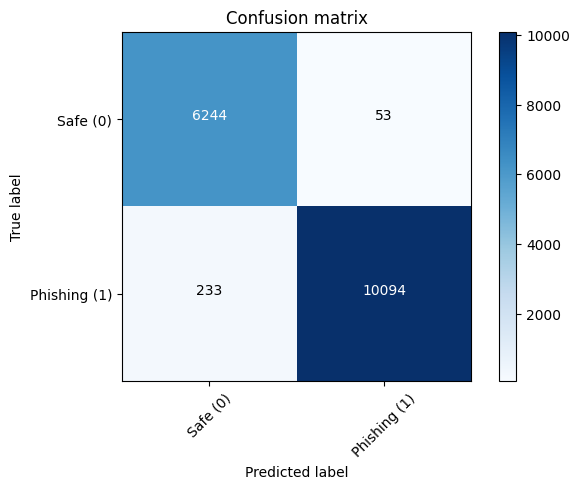

In [ ]:
y_pred = LGB_C.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, classes=['Safe (0)', 'Phishing (1)'], normalize=False)
plt.show()


In [ ]:
lgb_feature = lgb.feature_importances_
lgb_feature

array([300, 133,  10, 330,  43,  84,  98,  35, 141, 132, 304,  52, 588,
       266, 183, 301], dtype=int32)

In [ ]:
lgb_features = lgb_feature.tolist()

In [ ]:
import pickle
# saving model
lgbm_pkl = "lgbm.pkl"
with open(lgbm_pkl, 'wb') as file:
    pickle.dump(LGB_C, file)

### XGBoost

In [ ]:
xgb = XGBClassifier(n_estimators= 100)
xgb.fit(X_train,y_train)
y_predXGB = xgb.predict(X_test)
print(classification_report(y_test,y_predXGB))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

cv_scores = cross_val_score(
    xgb,
    X_train,
    y_train,
    cv=cv,
    scoring='accuracy'
)

print("Cross-val scores:", cv_scores)
print("Cross-val mean:", cv_scores.mean())
print("Cross-val std:", cv_scores.std())

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6297
           1       0.99      0.98      0.99     10327

    accuracy                           0.98     16624
   macro avg       0.98      0.98      0.98     16624
weighted avg       0.98      0.98      0.98     16624

Cross-val scores: [0.98451011 0.98202872 0.98526205 0.98345616 0.98360656]
Cross-val mean: 0.9837727206965365
Cross-val std: 0.0010891460503304879


In [ ]:
xgb_acc = accuracy_score(y_test, y_predXGB)
xgb_acc

0.9818936477382099

In [ ]:
xgb_f1_macro = f1_score(y_test, y_predXGB, average='macro')
xgb_f1_macro

0.9808646507652414

In [ ]:
xgb_f1_micro = f1_score(y_test, y_predXGB, average='micro')
xgb_f1_micro

0.9818936477382099

In [ ]:
xgb_f1_w = f1_score(y_test, y_predXGB, average='weighted')
xgb_f1_w

0.9819403596630526

In [ ]:
new_eval = {'Model': 'XGB','Accuracy': xgb_acc, 'F1-macro': xgb_f1_macro, 'F1-micro': xgb_f1_micro, 'F1-weighted': xgb_f1_w }
eval_df.loc[len(eval_df)] = new_eval

Confusion matrix, without normalization


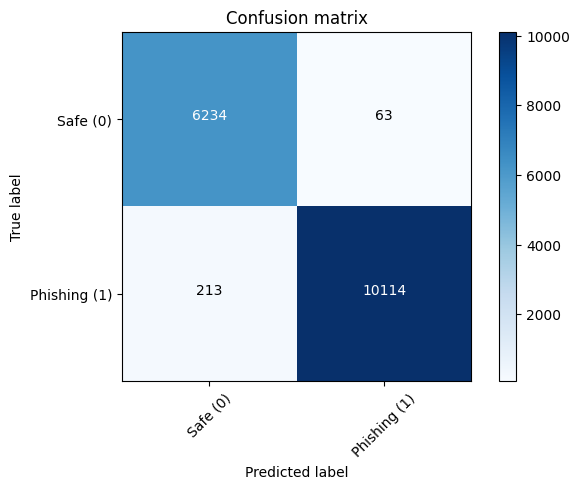

In [ ]:
CM = confusion_matrix(y_test, y_predXGB, labels=[0, 1])

plot_confusion_matrix(CM, classes=['Safe (0)', 'Phishing (1)'])

In [ ]:
xgb_feature = xgb.feature_importances_
xgb_features = xgb_feature.tolist()

In [ ]:
import pickle
# saving model
xgb_pkl = "xgb.pkl"
with open(xgb_pkl, 'wb') as file:
    pickle.dump(xgb, file)

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(n_estimators=100,max_features='sqrt')
gbdt.fit(X_train,y_train)
y_predGBDT = gbdt.predict(X_test)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

cv_scores = cross_val_score(
    gbdt,
    X_train,
    y_train,
    cv=cv,
    scoring='accuracy'
)
print("Cross-val scores:", cv_scores)
print("Cross-val mean:", cv_scores.mean())
print("Cross-val std:", cv_scores.std())

Cross-val scores: [0.97894579 0.97834424 0.98105121 0.9790194  0.97774101]
Cross-val mean: 0.9790203287527648
Cross-val std: 0.0011156855601574672


In [ ]:
gbdt_acc = accuracy_score(y_test, y_predGBDT)
gbdt_acc

0.9790062560153994

In [ ]:
gbdt_f1_macro = f1_score(y_test, y_predGBDT, average='macro')
gbdt_f1_macro

0.9778013578479421

In [ ]:
gbdt_f1_micro = f1_score(y_test, y_predGBDT, average='micro')
gbdt_f1_micro

0.9790062560153994

In [ ]:
gbdt_f1_w = f1_score(y_test, y_predGBDT, average='weighted')
gbdt_f1_w

0.9790550990343229

In [ ]:
new_eval = {'Model': 'GBDT','Accuracy': gbdt_acc, 'F1-macro': gbdt_f1_macro, 'F1-micro': gbdt_f1_micro, 'F1-weighted': gbdt_f1_w }
eval_df.loc[len(eval_df)] = new_eval

Confusion matrix, without normalization


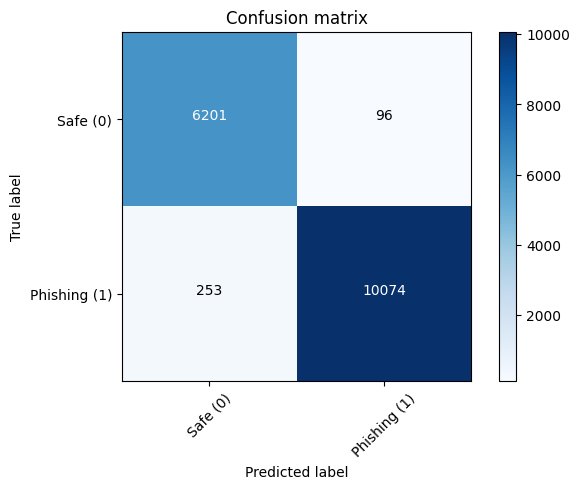

In [ ]:
CM = confusion_matrix(y_test, y_predGBDT, labels=[0, 1])
plot_confusion_matrix(CM, classes=['Safe (0)', 'Phishing (1)'])

In [ ]:
gbdt_feature = gbdt.feature_importances_
gbdt_features = gbdt_feature.tolist()

In [ ]:
import pickle
# saving model
gbdt_pkl = "gbdt.pkl"
with open(gbdt_pkl, 'wb') as file:
    pickle.dump(gbdt, file)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
y_predRF = rf.predict(X_test)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

cv_scores = cross_val_score(
    rf,
    X_train,
    y_train,
    cv=cv,
    scoring='accuracy'
)
print("Cross-val scores:", cv_scores)
print("Cross-val mean:", cv_scores.mean())
print("Cross-val std:", cv_scores.std())

Cross-val scores: [0.98601399 0.98315663 0.98548763 0.98488495 0.98360656]
Cross-val mean: 0.9846299494924804
Cross-val std: 0.0010894221887291107


In [ ]:
rf_acc = accuracy_score(y_test, y_predRF)
rf_acc

0.983337343599615

In [ ]:
rf_f1_macro = f1_score(y_test, y_predRF, average='macro')
rf_f1_macro

0.9823652801659528

In [ ]:
rf_f1_micro = f1_score(y_test, y_predRF, average='micro')
rf_f1_micro

0.983337343599615

In [ ]:
rf_f1_w = f1_score(y_test, y_predRF, average='weighted')
rf_f1_w

0.9833689736421657

In [ ]:
new_eval = {'Model': 'RF','Accuracy': rf_acc, 'F1-macro': rf_f1_macro, 'F1-micro': rf_f1_micro, 'F1-weighted': rf_f1_w }
eval_df.loc[len(eval_df)] = new_eval

Confusion matrix, without normalization


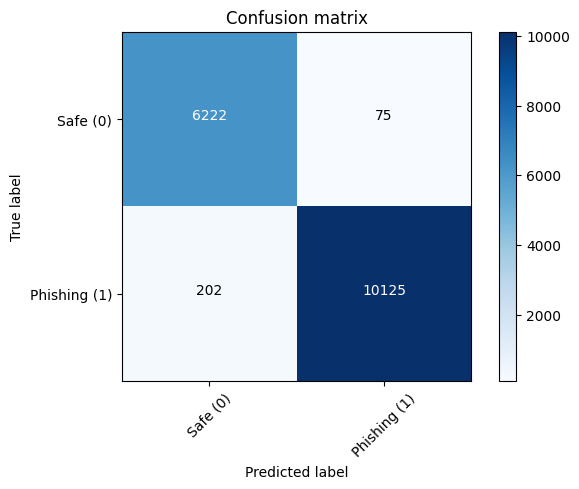

In [ ]:
CM = confusion_matrix(y_test, y_predRF, labels=[0, 1])

plot_confusion_matrix(CM, classes=['Safe (0)', 'Phishing (1)'])

In [ ]:
rf_feature = rf.feature_importances_
rf_features = rf_feature.tolist()

In [ ]:
import pickle
# saving model
rf_pkl = "rf.pkl"
with open(rf_pkl, 'wb') as file:
    pickle.dump(rf, file)

### Plotting Feature Importances

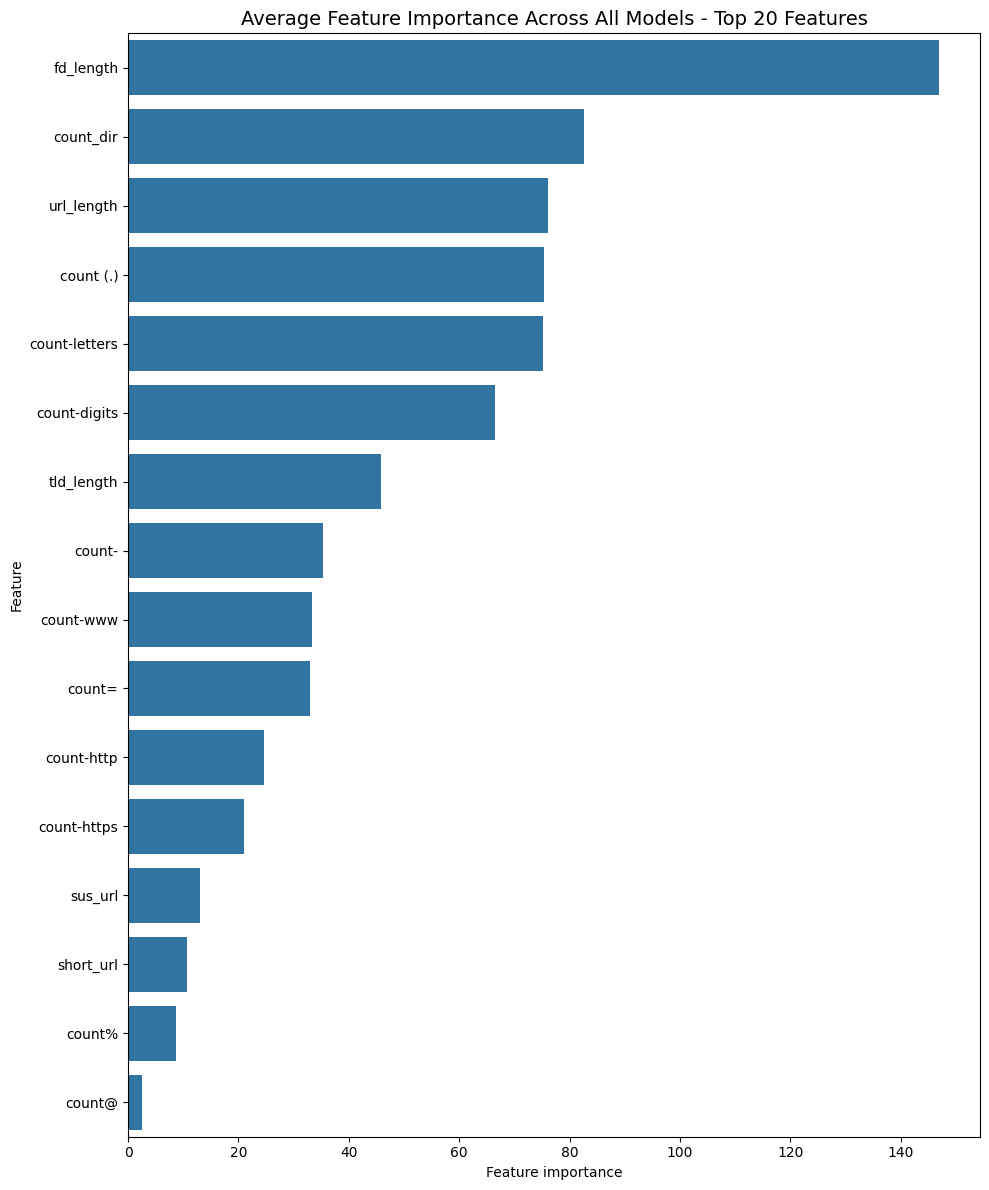

In [ ]:
%matplotlib inline

# Create feature_dataframe with all models feature importances
feature_dataframe = pd.DataFrame({
    'feature': X_train.columns,
    'Random Forest': rf.feature_importances_,
    'LGBM': lgb.feature_importances_,
    'XGBoost': xgb.feature_importances_,
    'Gradient Boosting': gbdt.feature_importances_
})

# Calculate mean importance across all models
feature_dataframe['mean'] = feature_dataframe[['Random Forest', 'LGBM', 'XGBoost', 'Gradient Boosting']].mean(axis=1)

def plot_feature_importance():
    tmp = pd.DataFrame({'Feature': X_test.columns, 'Feature importance': feature_dataframe['mean'].values})
    tmp = tmp.sort_values(by='Feature importance',ascending=False).head(20)
    plt.figure(figsize = (10,12))
    plt.title('Average Feature Importance Across All Models - Top 20 Features',fontsize=14)
    s = sns.barplot(y='Feature',x='Feature importance',data=tmp, orient='h')
    plt.tight_layout()
    plt.show()

plot_feature_importance()

## Final Result

In [ ]:
eval_df.sort_values(by=['F1-weighted','Accuracy'], ascending=False)

,Model,Accuracy,F1-macro,F1-micro,F1-weighted
1,XGB,0.983397,0.982441,0.983397,0.983434
3,RF,0.983337,0.982365,0.983337,0.983369
0,LGBM,0.982796,0.981821,0.982796,0.982842
2,GBDT,0.979006,0.977801,0.979006,0.979055


In [ ]:
eval_df.to_csv('./eval-df.csv')